Name: Ulrich GOUE

Mail: UlrichSilvere.GOUE-GNOLEBA@ensae-paristech.fr

In [1]:
# Install PyTorch (http://pytorch.org/)
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1.post4-{platform}-linux_x86_64.whl torchvision
#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision 
 
import torch
print(torch.__version__)
print(torch.cuda.is_available())

    100% |████████████████████████████████| 512.6MB 50.2MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58c52000 @  0x7f5ce1a942a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 12.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
0.4.1
True


In [2]:
import zipfile
!wget https://www.di.ens.fr/willow/teaching/recvis18/assignment3/bird_dataset.zip
archive = zipfile.ZipFile('/content/bird_dataset.zip', 'r')
!unzip "/content/bird_dataset.zip"

--2018-11-20 14:55:47--  https://www.di.ens.fr/willow/teaching/recvis18/assignment3/bird_dataset.zip
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 192388716 (183M) [application/zip]
Saving to: ‘bird_dataset.zip’

bird_dataset.zip    100%[===================>] 183.48M  8.68MB/s    in 37s     

2018-11-20 14:56:25 (5.02 MB/s) - ‘bird_dataset.zip’ saved [192388716/192388716]

Archive:  /content/bird_dataset.zip
   creating: bird_dataset/
   creating: bird_dataset/test_images/
   creating: bird_dataset/test_images/mistery_category/
  inflating: bird_dataset/test_images/mistery_category/002f61512a368e4c1434eedacf609957.jpg  
  inflating: bird_dataset/test_images/mistery_category/0247efd7b9d47d036bb4390202a13e69.jpg  
  inflating: bird_dataset/test_images/mistery_category/0267548c2aac82fe3d7e37ae98b00bd7.jpg  
  inflating: bird_dataset/test_images/mis

## Data

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 64 x 64 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transforms_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [0]:
# Data initialization and loading
"""
from data import data_transforms
"""
dataset = 'bird_dataset'
batch_size = 8

train_datasets = datasets.ImageFolder(dataset + '/train_images',
                         transform=data_transforms_train)

train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True, num_workers=1)

val_datasets =  datasets.ImageFolder(dataset + '/val_images',transform=data_transforms_val)
val_loader = torch.utils.data.DataLoader(val_datasets,batch_size=batch_size, shuffle=False, num_workers=1)


dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train':len(train_datasets), 'val':len(val_datasets)}

class_names_train = train_datasets.classes

In [5]:
!pip install Pillow==4.0.0

    100% |████████████████████████████████| 5.6MB 7.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


### Visualize some images

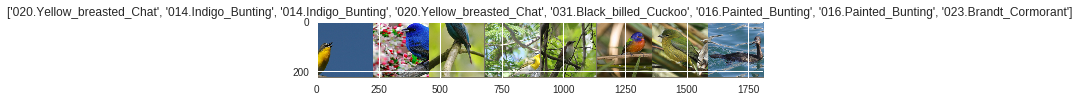

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names_train[x] for x in classes])

# Models

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
#device="cpu"
torch.manual_seed(123)


def model_choice(name='resnet152'):
  if name =='vgg19_bn':
    model_ft = models.vgg19_bn(pretrained='imagenet')
    num_ftrs = model_ft.classifier[6].in_features
    features = list(model_ft.classifier.children())[:-1]
    model_ft.classifier = nn.Sequential(*features)
  else:
    if name=='resnet152':
      model_ft = models.resnet152(pretrained=True)
    elif name=='resnet101':
      model_ft = models.resnet101(pretrained=True)
    else:
      model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 20)
  return model_ft.to(device)



name = 'resnet152'
model_ft = model_choice(name=name)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:04<00:00, 54021931.21it/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

#we can keep training by increasing the number of epochs

Epoch 0/9
----------
train Loss: 2.2291 Acc: 0.3789
val Loss: 0.8558 Acc: 0.7379

Epoch 1/9
----------
train Loss: 1.0759 Acc: 0.6941
val Loss: 0.4570 Acc: 0.8447

Epoch 2/9
----------
train Loss: 0.8141 Acc: 0.7542
val Loss: 0.4451 Acc: 0.8447

Epoch 3/9
----------
train Loss: 0.7136 Acc: 0.7773
val Loss: 0.3635 Acc: 0.8738

Epoch 4/9
----------
train Loss: 0.6606 Acc: 0.8087
val Loss: 0.4141 Acc: 0.8641

Epoch 5/9
----------
train Loss: 0.5808 Acc: 0.8189
val Loss: 0.4161 Acc: 0.8350

Epoch 6/9
----------
train Loss: 0.5670 Acc: 0.8327
val Loss: 0.4962 Acc: 0.8447

Epoch 7/9
----------
train Loss: 0.5326 Acc: 0.8401
val Loss: 0.4163 Acc: 0.8544

Epoch 8/9
----------
train Loss: 0.4508 Acc: 0.8641
val Loss: 0.3514 Acc: 0.8738

Epoch 9/9
----------
train Loss: 0.3863 Acc: 0.8919
val Loss: 0.3366 Acc: 0.8738

Training complete in 13m 48s
Best val Acc: 0.873786


In [0]:
filename = 'model_%s.pth'%name
import torch
from google.colab import files

torch.save(model_ft, filename) # save a trained model on the VM

In [12]:
files.download(filename) # download the model to local

# select the model just downloaded
#model_ft = files.upload() 

# access the model
#model_ft = torch.load(filename)

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 37202, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
from tqdm import tqdm
import os
import PIL.Image as Image

In [14]:
test_dir = dataset+ '/test_images/mistery_category'
print(test_dir)

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

bird_dataset/test_images/mistery_category


In [16]:
from google.colab import drive
drive.mount('/content/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [17]:
outfile = 'kaggle.csv'
#output_file = open(outfile, "w")

use_cuda = torch.cuda.is_available()

output_file = open('/content/gdrive/My Drive/MVA/OBJECT_RECOGNITION/kaggle.csv', 'w')

output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms_val(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model_ft(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

100%|██████████| 517/517 [00:33<00:00, 15.63it/s]

Succesfully wrote kaggle.csv, you can upload this file to the kaggle competition website
